In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/random-linear-regression/train.csv
/kaggle/input/random-linear-regression/test.csv


#  **Linear Regression**

**1. Data Preprocessing**

    A) First Glimpse at Data
    
    B) Handle with missing value
    
    C) Handle with outliers
        
**2. Regression with Sckit-Learn**

**3. Model Evaluation**

    A) Mean Squared Error
    
    B) Mean Absolute Error
    
    C) R-squared
    

In [2]:
# Libraries 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pyplot
import seaborn as sns
from scipy import stats
from numpy import asarray
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error

# 1. **Data Preprocessing**

**A) **First Glimpse at Data****

In [3]:
# Lets look at the data

df_train = pd.read_csv('/kaggle/input/random-linear-regression/train.csv')
df_test = pd.read_csv('/kaggle/input/random-linear-regression/test.csv')

In [4]:
df_train.head()

,x,y
0,24.0,21.549452
1,50.0,47.464463
2,15.0,17.218656
3,38.0,36.586398
4,87.0,87.288984


In [5]:
df_train.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
x,700.0,54.985939,134.681703,0.000000,25.000000,49.00000,75.000000,3530.157369
y,699.0,49.939869,29.109217,-3.839981,24.929968,48.97302,74.929911,108.871618


When we look at the data by quick way with the describe function, wee see one missing value in the "y" column in the train dataset. 

In [6]:
df_test.head()

,x,y
0,77,79.775152
1,21,23.177279
2,22,25.609262
3,20,17.857388
4,36,41.849864


In [7]:
df_test.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
x,300.0,50.936667,28.504286,0.000000,27.000000,53.000000,73.000000,100.000000
y,300.0,51.205051,29.071481,-3.467884,25.676502,52.170557,74.303007,105.591837


In the test dataset, there is no any missing value.

**B) Handle with Missing Values**

In [8]:
# we detect one missing value in train dataset, lets look at it by the isnull function

df_train.isnull().sum()

x    0
y    1
dtype: int64

In [9]:
df_train[df_train.isna().any(axis=1)]

,x,y
213,3530.157369,NaN


In [10]:
# Missing value in terms of ratio in the dataset

df_train.y.isnull().sum()/len(df_train.y)

0.0014285714285714286

In [11]:
# Lets drop the missin value. Only one value is missing, so there is no need to imputation

df_train.dropna(inplace=True)

df_train.shape

(699, 2)

**C) Handle with Outliers**

There ara a lot ways to determine outliers, including
* Standart Deviation
* Quartile Range
* Z score
* Winsorization
* Local Outlier Factor
...

We will use **Standart Deviation** method to find outliers in the analysis.

In [12]:
# calculate mean and std of data

data_std_Y=df_train.y.std()
data_mean_Y=df_train.y.mean()

data_std_X=df_train.x.std()
data_mean_X=df_train.x.mean()


# we use 3 stardart deviation to determine cut off point

lower_y, upper_y = data_mean_Y- 3 * data_std_Y, data_mean_Y + 3 * data_std_Y

lower_x, upper_x = data_mean_X- 3 * data_std_X, data_mean_X + 3 * data_std_X

print("For Y dimension; Std : {}, Mean : {}, Lower : {}, Upper : {}".format(data_std_Y,data_mean_Y,lower_y,upper_y))

print("For X dimension; Std : {}, Mean : {}, Lower : {}, Upper : {}".format(data_std_X,data_mean_X,lower_x,upper_x))

# detect outlier

outliers_std_X = [x for x in df_train.x if x < lower_x or x > upper_x]

outliers_std_Y = [x for x in df_train.y if x < lower_y or x > upper_y]

For Y dimension; Std : 29.109217100389866, Mean : 49.93986917045776, Lower : -37.387782130711834, Upper : 137.26752047162736
For X dimension; Std : 28.954560214557873, Mean : 50.01430615164521, Lower : -36.84937449202841, Upper : 136.87798679531883


In [13]:
outliers_std_X

[]

In [14]:
outliers_std_Y

[]

We see that our outlier list for X columns return empty, so there is no outlier in the dataset for X dimension. Also, we reach same result for Y dimension. Therefore, we do not need to remove outliers from our dataset. However, lets look at data by a visualization

{'whiskers': [<matplotlib.lines.Line2D at 0x7e7486979a50>,
 'caps': [<matplotlib.lines.Line2D at 0x7e7486988110>,
 'boxes': [<matplotlib.lines.Line2D at 0x7e7486979650>,
 'medians': [<matplotlib.lines.Line2D at 0x7e7486988750>,
 'fliers': [<matplotlib.lines.Line2D at 0x7e7486988a90>,
 'means': []}

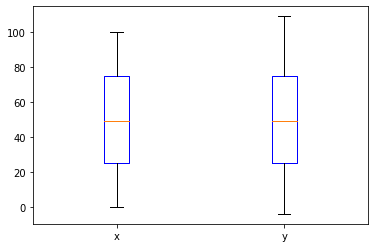

In [15]:
# simple box-plot visualization

plt.boxplot([df_train.x,df_train.y],   boxprops=dict(color='blue'), labels=['x','y'])

# **2. Regression with Sckit-Learn**

First of all, we reshape our data to apply Linear Regression formula, then we call Linear Regression function from Sckit-Learn library and predict our data.

In [16]:
# Reshape train and test data to apply regression

X_train = df_train['x'].values.reshape(-1,1)
Y_train = df_train['y'].values.reshape(-1,1)

X_test = df_test['x'].values.reshape(-1,1)
Y_test = df_test['y'].values.reshape(-1,1)

In [17]:
# Call Linear Regression fuction

from sklearn.linear_model import LinearRegression

lr = LinearRegression() # create lr object to fit our data

lr.fit(X_train,Y_train) # fit the formula our train dataset

LinearRegression()

In [18]:
# Make Prediction Test Data

y_pred = lr.predict(X_test)

df_test['Predicted'] = y_pred

df_test

,x,y,Predicted
0,77,79.775152,76.943276
1,21,23.177279,20.906519
2,22,25.609262,21.907175
3,20,17.857388,19.905862
4,36,41.849864,35.916364
...,...,...,...
295,71,68.545888,70.939338
296,46,47.334876,45.922928
297,55,54.090637,54.928836
298,62,63.297171,61.933430


# **3. Model Evaluation**

So far now, we made prediction. Then, we evaluate performance of our model. For that, there are a lot metrics, including;

**Mean Squared Error**

**Mean Absolute Error**

**R-squared****

Root Mean-squared Error

Root Mean Squared Log Error

Adjusted R Squared


..

We will look at above first 3 metrics to understand success of our model.

**A) Mean Squared Error -- MSE**

In [19]:
#Calculation of Mean Squared Error (MSE)

# Test Data
Test_data_MSE = mean_squared_error(Y_test,df_test.Predicted)

Test_data_MSE

9.432922192039305

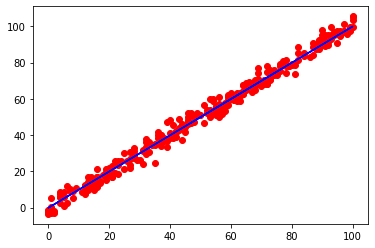

In [20]:
# y and y_pred visualiation

plt.scatter(X_test, Y_test, color = 'red')
plt.plot(X_test,df_test.Predicted, color = 'blue')

**B) Mean Absolute Error**

In [21]:
#Calculation of Mean Absolute Error (MAE)

# Test Data
Test_data_MAE = mean_absolute_error(Y_test,df_test.Predicted)

Test_data_MAE

2.415771850041258

In [22]:
#Calculation of r2_score (R2)

# Test Data
Test_data_R2 = r2_score(Y_test,df_test.Predicted)

Test_data_R2

0.9888014444327563